# **Ajustes do DF**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('df_producao_total.csv', sep=',')
df.head()

,data,producao
0,1997-01-01,812324
1,1997-02-01,818768
2,1997-03-01,846938
3,1997-04-01,818238
4,1997-05-01,786930


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   data      343 non-null    object
 1   producao  343 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ KB


In [4]:
df["data"] = pd.to_datetime(df["data"], errors="coerce")
df["data"] = df["data"].dt.to_period("M").dt.to_timestamp()
df = df.set_index("data").sort_index()
print(df.head())
print(df.index.dtype)

            producao
data                
1997-01-01    812324
1997-02-01    818768
1997-03-01    846938
1997-04-01    818238
1997-05-01    786930
datetime64[ns]


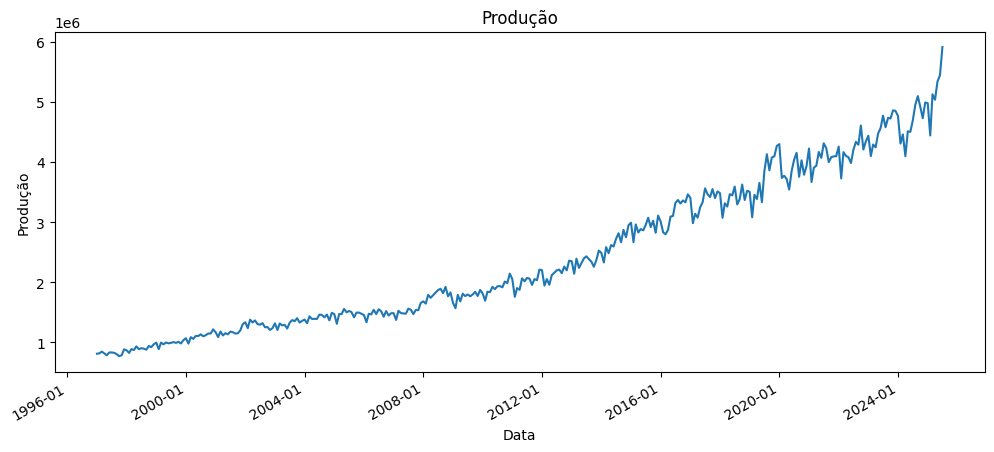

In [5]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
plt.plot(df.index, df["producao"])

plt.title("Produção")
plt.xlabel("Data")
plt.ylabel("Produção")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()

plt.show()

In [6]:
ts = df['producao']
ts['2004-05-01']

1392775

In [7]:
ts['2004-05':'2004-12']

,producao
data,
2004-05-01,1392775
2004-06-01,1390781
2004-07-01,1463457
2004-08-01,1457531
2004-09-01,1417593
2004-10-01,1464051
2004-11-01,1366916
2004-12-01,1492926


# **Decomposição**

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
decomposicao = seasonal_decompose(ts, period=12)

In [10]:
tendencia = decomposicao.trend

In [11]:
#sozonalidade
sazonal = decomposicao.seasonal

In [12]:
#erro
aleatorio = decomposicao.resid

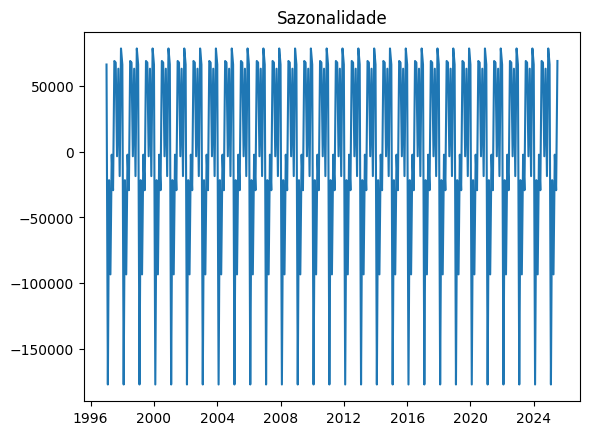

In [13]:
plt.plot(sazonal)
plt.title('Sazonalidade')
plt.show()

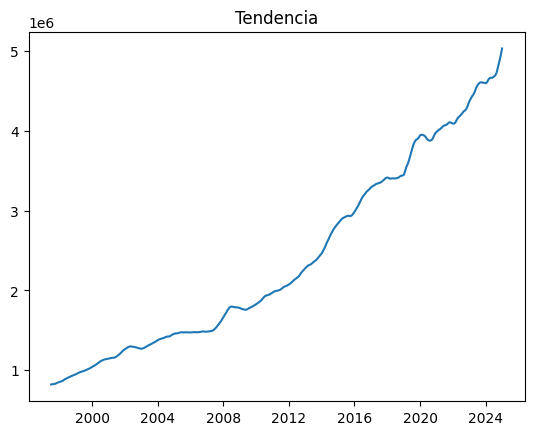

In [14]:
plt.plot(tendencia)
plt.title('Tendencia')
plt.show()

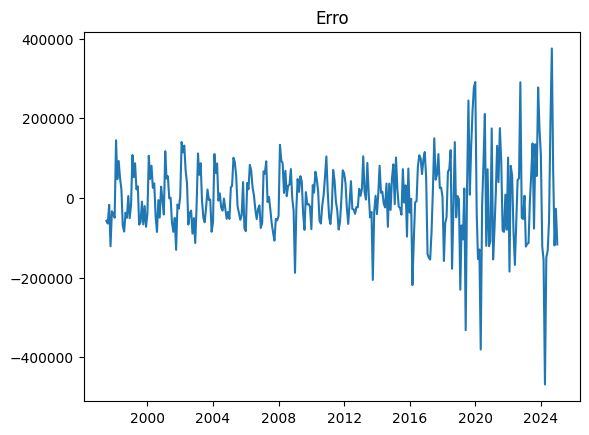

In [15]:
plt.plot(aleatorio)
plt.title('Erro')
plt.show()

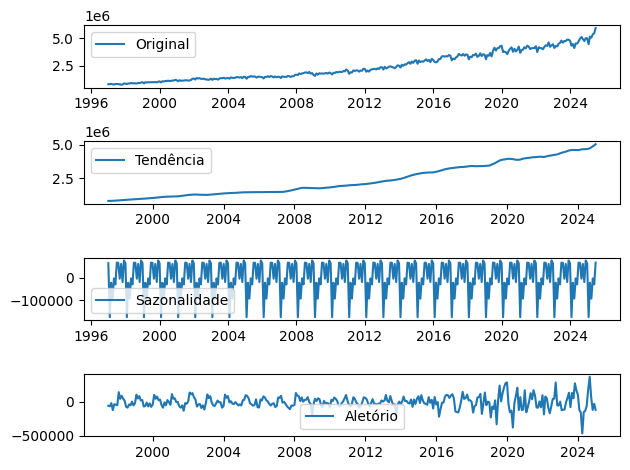

In [16]:
plt.subplot(4,1,1)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')

# Visualização somente da tendência
plt.subplot(4,1,2)
plt.plot(tendencia, label = 'Tendência')
plt.legend(loc = 'best')

# Visualização somente da sazonalidade
plt.subplot(4,1,3)
plt.plot(sazonal, label = 'Sazonalidade')
plt.legend(loc = 'best')

# Visualização somente do elemento aleatório
plt.subplot(4,1,4)
plt.plot(aleatorio, label = 'Aletório')
plt.legend(loc = 'best')
plt.tight_layout()

# **Holt Winters**

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
#separate train/validation
train, val, test = ts['1997-01':'2021-12'], ts['2022-01':'2023-12'], ts['2024-01':]

In [19]:
#aditivo e multiplicativo
m = 12
models = {}
for seasonal in ['add', 'mul']:
    model = ExponentialSmoothing(
        train, trend='add', seasonal=seasonal, seasonal_periods=m
    ).fit()
    forecast_val = model.forecast(len(val))
    mae_val = mean_absolute_error(val, forecast_val)
    rmse_val = np.sqrt(mean_squared_error(val, forecast_val))
    mape_val = np.mean(np.abs((val - forecast_val) / val)) * 100
    models[seasonal] = {'model': model, 'forecast_val': forecast_val, 'mae_val': mae_val, 'rmse_val': rmse_val, 'mape_val': mape_val}
    print(f"{seasonal} -> MAE na validação: {mae_val:.2f}")
    print(f"{seasonal} -> RMSE na validação: {rmse_val:.2f}")
    print(f"{seasonal} -> MAPE na validação: {mape_val:.2f}%")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


add -> MAE na validação: 244581.45
add -> RMSE na validação: 297156.43
add -> MAPE na validação: 5.42%
mul -> MAE na validação: 241382.45
mul -> RMSE na validação: 293765.04
mul -> MAPE na validação: 5.34%


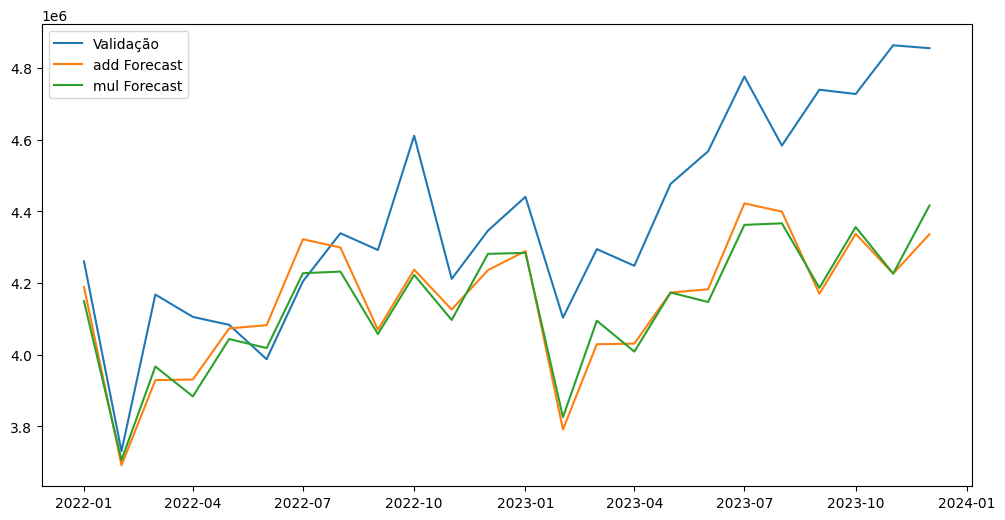

In [20]:
#plot dos dois modelos
plt.figure(figsize=(12, 6))
plt.plot(val.index, val, label='Validação')
for seasonal in ['add', 'mul']:
    plt.plot(val.index, models[seasonal]['forecast_val'], label=f'{seasonal} Forecast')
plt.legend()
plt.show()

In [21]:
best_seasonal = min(models, key=lambda k: models[k]['mae_val'])
print(f"Melhor modelo pela validação: {best_seasonal}")

Melhor modelo pela validação: mul


**Modelo Final**

In [22]:
final_train = ts['1997-01':'2023-12']
final_model_holtwinters = ExponentialSmoothing(
    final_train, trend='add', seasonal=best_seasonal, seasonal_periods=m
).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [23]:
forecast_test = final_model_holtwinters.forecast(len(test))
mae_test = mean_absolute_error(test, forecast_test)
rmse_test = np.sqrt(mean_squared_error(test, forecast_test))
mape_test = np.mean(np.abs((test - forecast_test) / test)) * 100
accuracy = 100 - mape_test
print(f"Erro final no teste: {mae_test:.2f}")
print(f"RMSE final no teste: {rmse_test:.2f}")
print(f"MAPE final no teste: {mape_test:.2f}%")
print(f"Acurácia final no teste: {accuracy:.2f}%")

Erro final no teste: 256144.72
RMSE final no teste: 302205.88
MAPE final no teste: 5.23%
Acurácia final no teste: 94.77%


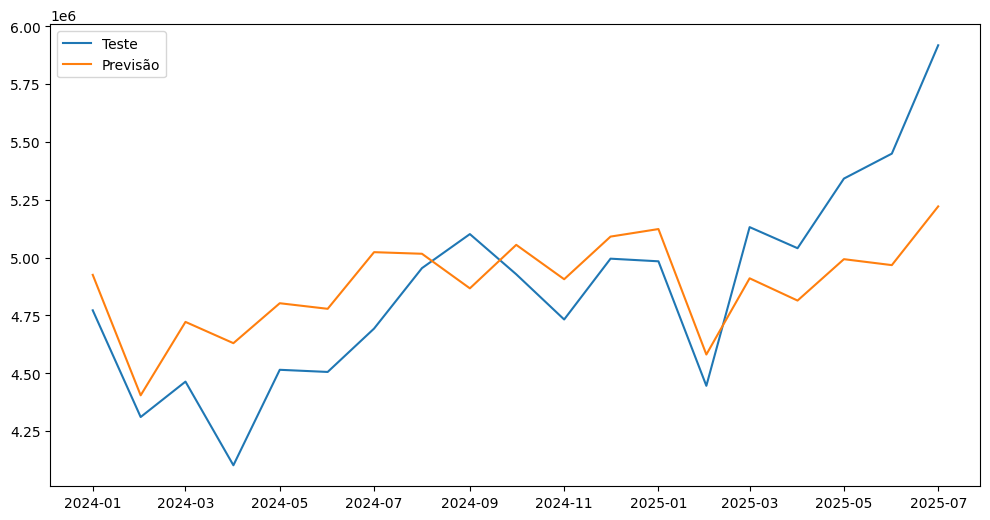

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Teste')
plt.plot(test.index, forecast_test, label='Previsão')
plt.legend()
plt.show()

In [25]:
print(final_model_holtwinters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 producao   No. Observations:                  324
Model:             ExponentialSmoothing   SSE                  2205859002047.766
Optimized:                         True   AIC                           7367.812
Trend:                         Additive   BIC                           7428.304
Seasonal:                Multiplicative   AICC                          7370.054
Seasonal Periods:                    12   Date:                 Wed, 24 Sep 2025
Box-Cox:                          False   Time:                         20:59:04
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6188188                alpha                 True
smoothing_trend          

# **ARIMA/SARIMA**

In [26]:
from pmdarima.arima import auto_arima

In [27]:
#separate train/validation
train, val, test = ts['1997-01':'2021-12'], ts['2022-01':'2023-12'], ts['2024-01':]

In [28]:
stepwise_model = auto_arima(ts, start_p=1,start_q=1,start_d= 0, start_P=0, max_p=6, max_q=6, m=12, seasonal=True, trace=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9164.223, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=9098.341, Time=0.19 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=9066.504, Time=0.47 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=9054.447, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=9030.456, Time=0.35 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=9027.339, Time=0.82 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=9025.977, Time=0.65 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=9023.963, Time=1.65 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=9103.627, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9048.648, Time=0.26 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=9020.628, Time=0.77 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=9021.311, Time=0.26 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=9017.208, Time=1.30 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=9006.211, Time=2.58 sec


In [29]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [30]:
previsao_arima = stepwise_model.predict(n_periods=len(val))

In [31]:
mae_val = mean_absolute_error(val, previsao_arima)
rmse_val = np.sqrt(mean_squared_error(val, previsao_arima))
mape_val = np.mean(np.abs((val - previsao_arima) / val)) * 100
accuracy = 100 - mape_val
print(f"Erro final na validação: {mae_test:.2f}")
print(f"RMSE final na validação: {rmse_test:.2f}")
print(f"MAPE final na validação: {mape_test:.2f}%")
print(f"Acurácia final na validação: {accuracy:.2f}%")

Erro final na validação: 256144.72
RMSE final na validação: 302205.88
MAPE final na validação: 5.23%
Acurácia final na validação: 96.41%


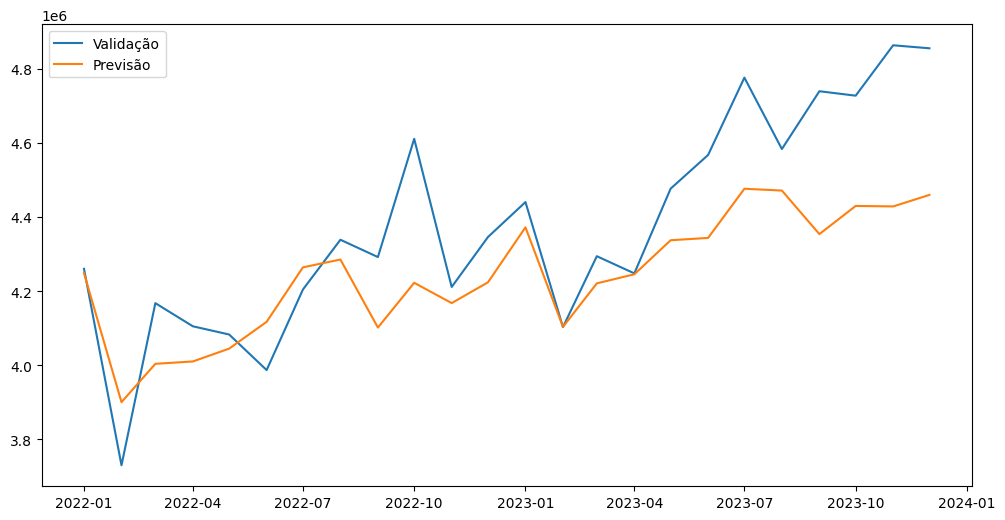

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(val.index, val, label='Validação')
plt.plot(val.index, previsao_arima, label='Previsão')
plt.legend()
plt.show()

In [33]:
final_train = ts['1997-01':'2023-12']
stepwise_model.fit(final_train)
previsao_final_arima = stepwise_model.predict(n_periods=len(test))

In [34]:
mae_test_arima = mean_absolute_error(test, previsao_final_arima)
rmse_test_arima = np.sqrt(mean_squared_error(test, previsao_final_arima))
mape_test_arima = np.mean(np.abs((test - previsao_final_arima) / test)) * 100
accuracy_arima = 100 - mape_test_arima
print(f"Erro final no teste: {mae_test_arima:.2f}")
print(f"RMSE final no teste: {rmse_test_arima:.2f}")
print(f"MAPE final no teste: {mape_test_arima:.2f}%")
print(f"Acurácia final no teste: {accuracy_arima:.2f}%")

Erro final no teste: 342633.47
RMSE final no teste: 397638.91
MAPE final no teste: 7.37%
Acurácia final no teste: 92.63%


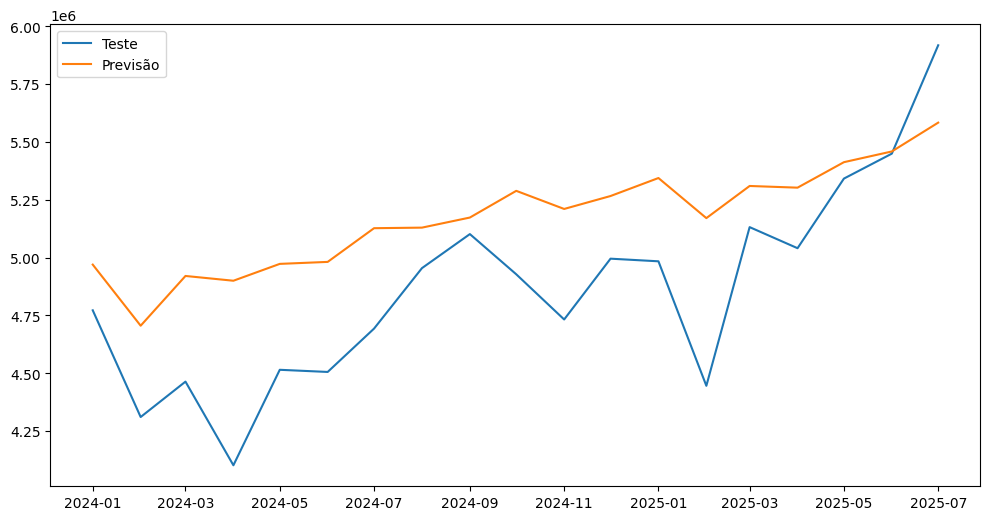

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Teste')
plt.plot(test.index, previsao_final_arima, label='Previsão')
plt.legend()
plt.show()